## Assignment 1 

A) Load the datasets and deal with missing values if applicable in a proper way and describe how you did it. One way you can do it is to replace the value with the mean value of the feature in the training set.


B) Implement (1) a decision stump, (2) an unpruned decision tree, (3) a pruned decision tree. Apply (1)-(3) on each dataset. Implement these methods from scratch, do not use ready implementations such as available in scikit-learn for this task. You can use pre-pruning and / or post-pruning techniques as your pruning strategy to obtain the pruned decision tree. Explain the pruning techniques you used.

C) Use a proper way to select your hyperparameters such as depth. Explain how you did it. Explain the observation you got from different datasets, and discuss the possible reason.

D) Compare the three methods used in task 2 and determine if any are performing significantly worse on each dataset. Report the p-value for the significance tests. Explain why the worst method performs worse than others.

#### 1.1 Overview 

**Load in Python Modules**: All modules required to run any data processing will be all loaded at the start. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as s
import os

from time import time
from typing import Any, Union
from collections import Counter
from itertools import product
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('seaborn-v0_8')

#### Helper Functions

Helper Functions used to avoid repeating code where possible, and to assist presenting data in a clean format.

In [2]:
class DataLoad:
    def __init__(self, path: str = './data/'):
        self._path = path
        self._datasets = {}
        
    def loadData(self, df_name: str = None):
        df = pd.read_csv(os.path.join(self._path, df_name))
        df.name = os.path.splitext(df_name)[0]
        
        # Inconsistent spacing and leading/trailing spaces captured in column names. 
        df.columns = df.columns.str.strip() 
        self._datasets[df.name] = df
        return df
    
    def printSummary(self, df_name: str):
        if df_name not in self._datasets:
            print(f"{df_name} doesn't exist! Try loading data again. ")
            return
        
        print(f"{df_name}")
        print('----------')
        print(f"Number of Examples in {df_name}: {self._datasets[df_name].shape[0]}")
        print(f'Number of Features in {df_name}: {self._datasets[df_name].shape[1]}')
        print(f"Arrhythmia Shape: {self._datasets[df_name].shape}")
        print(self._datasets[df_name].columns)
        print('\n')
    
    def printSummaryStats(self, df: str, types: str | list = None) -> pd.DataFrame:
        return self._datasets[df].describe(include=types)
    
    def getDataLabels(self):
        return list(self._datasets)

    def getAllData(self):
        return self._datasets.values()

class EDA:
    def __init__(self):
        pass
    
    def checkMissing(self, df: pd.DataFrame = None) -> bool:
        if not len(df): 
            return 0
        
        tmp = df.replace('?', np.NaN)
        return (tmp.isna().any().sum() > 0)

    def getMissingRecords(self, df: pd.DataFrame = None) -> list:
        tmp = df.replace('?', np.NaN)
        return df.loc[:, tmp.isna().any()]
    
    def displayMissingSummary(self, df: pd.DataFrame = None) -> pd.DataFrame:
        placeholder_char = '?'
        missing_vals = df.apply(lambda x: x == placeholder_char).sum()
        missing_prop = (missing_vals / len(df)) * 100
        missing_summary = pd.concat([missing_vals, missing_prop], axis=1)
        missing_summary.columns = ['Missing Values', 'Missing Proportion']
        return missing_summary[missing_vals > 0]
    
    def plotBarMissing(self, df: pd.DataFrame = None) -> pd.DataFrame:
        placeholder_char = '?'
        missing_vals = df.apply(lambda x: x == placeholder_char).sum()
        missing_vals = missing_vals[missing_vals > 0]
        
        plt.figure(figsize=(10, 6))
        plt.bar(missing_vals.index, missing_vals)
        plt.xlabel('Variables')
        plt.ylabel('Number of Missing Values')
        plt.title('Count of Missing Values')
        plt.show()
        
    def plot_continuous_distribution(self, df: pd.DataFrame = None, column: str = None, height: int = 8):
        sns.displot(df, x=column, kde=True, aspect=height/5, linewidth=1, edgecolor='black')
        plt.grid(axis='y', linestyle='--')
    
    def get_unique_values(self, df: pd.DataFrame = None, column: str = None):
        n_unique = len(df[column].unique())
        uniqueArr = df[column].value_counts()
        print(f"Column: {column} has {n_unique} unique values. \n")
        print(uniqueArr)
    
    def plot_categorical_distribution(self, df: pd.DataFrame = None, column: str = None, height: int = 8):
        sns.catplot(data=df, x=column, height=8, aspect=height/5, kind='count')
        
    def data_split(self, df: pd.DataFrame = None):
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1].values.reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test

#### Loading Input Data

There is no missing data in BCP or Website Phishing datasets. However, there is missing data in Arrhythmia. 

In [3]:
load = DataLoad()
eda = EDA()

dfA = load.loadData('Arrhythmia.csv')
dfB = load.loadData('BCP.csv')
dfC = load.loadData('Website_Phishing.csv')

dfA.name = 'Arrhythmia'
dfB.name = 'BCP'
dfC.name = 'Website_Phishing'

dfs = [dfA, dfB, dfC]

In [4]:
load.printSummary('Arrhythmia')
load.printSummary('BCP')
load.printSummary('Website_Phishing')

Arrhythmia
----------
Number of Examples in Arrhythmia: 452
Number of Features in Arrhythmia: 280
Arrhythmia Shape: (452, 280)
Index(['age', 'sex', 'height', 'weight', 'QRSduration', 'PRinterval',
       'Q-Tinterval', 'Tinterval', 'Pinterval', 'QRS',
       ...
       'chV6_QwaveAmp', 'chV6_RwaveAmp', 'chV6_SwaveAmp', 'chV6_RPwaveAmp',
       'chV6_SPwaveAmp', 'chV6_PwaveAmp', 'chV6_TwaveAmp', 'chV6_QRSA',
       'chV6_QRSTA', 'class'],
      dtype='object', length=280)


BCP
----------
Number of Examples in BCP: 683
Number of Features in BCP: 11
Arrhythmia Shape: (683, 11)
Index(['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')


Website_Phishing
----------
Number of Examples in Website_Phishing: 11055
Number of Features in Website_Phishing: 31
Arrhythmia Shape: (11055, 3

In [5]:
print(f"Arrhythmia: {eda.checkMissing(dfA)}")
print(f"BCP: {eda.checkMissing(dfB)}")
print(f"Website_Phishing: {eda.checkMissing(dfC)}")

Arrhythmia: True
BCP: False
Website_Phishing: False


#### 1.1.1 Initial Exploration of `Arrhythmia` Data

There is missing data.

In [6]:
dfA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to class
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB


In [7]:
load.printSummaryStats('Arrhythmia', 'int64')

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,...,chV6_RPwave,chV6_SPwave,chV6_intrinsicReflecttions,chV6_RRwaveExists,chV6_DD_RRwaveExists,chV6_RPwaveExists,chV6_DD_RPwaveExists,chV6_RTwaveExists,chV6_DD_RTwaveExists,class
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.0,452.0,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,0.150442,0.0,32.168142,0.002212,0.002212,0.004425,0.0,0.0,0.011062,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,1.868024,0.0,10.272045,0.047036,0.047036,0.066445,0.0,0.0,0.104708,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,0.000000,0.0,24.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,0.0,28.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,0.0,40.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,28.000000,0.0,104.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,16.000000


In [8]:
load.printSummaryStats('Arrhythmia', 'object')

,T,P,QRST,J,heartrate
count,452,452,452,452,452
unique,171,102,135,70,64
top,52,60,62,?,63
freq,13,23,9,376,21


#### 1.1.2 Missing Values in `Arrhythmia`

Checking for null values suggests no missing values.

Further inspection shows that missing values take the form of placeholder values ie. '?'

In [9]:
eda.getMissingRecords(dfA)

,T,P,QRST,J,heartrate
0,13,64,-2,?,63
1,37,-17,31,?,53
2,34,70,66,23,75
3,11,-5,20,?,71
4,13,61,3,?,?
...,...,...,...,...,...
447,4,40,-27,?,63
448,66,52,79,?,73
449,-19,-61,-70,84,84
450,29,-22,43,103,80


In [10]:
# no need to check for BCP or Website Phishing since no missing values found
eda.displayMissingSummary(dfA)

,Missing Values,Missing Proportion
T,8,1.769912
P,22,4.867257
QRST,1,0.221239
J,376,83.185841
heartrate,1,0.221239


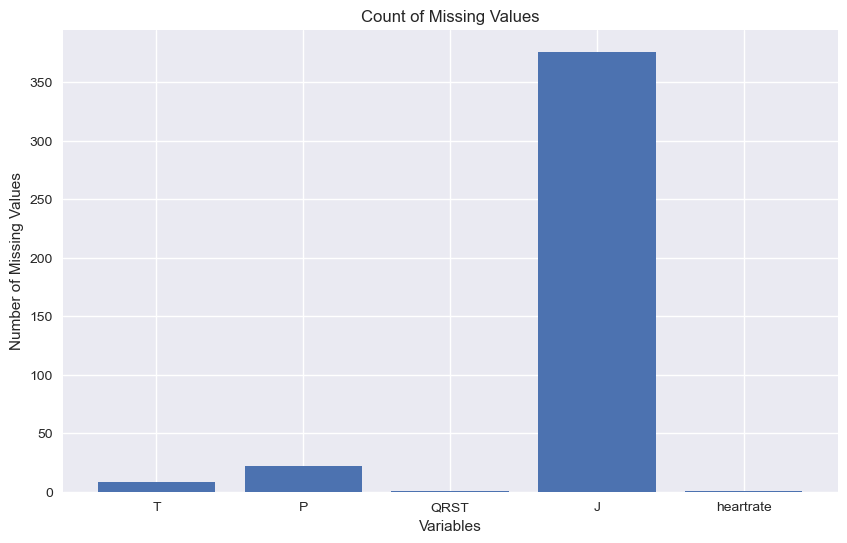

In [11]:
eda.plotBarMissing(dfA)

#### 1.1.3 Determining `Arrhythmia` Imputation Strategy

Missing values are an issue as they introduce bias and can lead to misleading and/or incorrect results.

The relationship of missingness can be seen below categorised by the target feature, `class`. There is no interaction between missingness and data occurance, so is not MAR nor NMAR. From these plots, we can determine the data is **Missing Completely at Random (MCAR)**.

A correlation close to 1 indicates a strong positive / correlation. 

The approach to imputing is as below:

- The feature `J` has high missingness (~83%), imputation becomes less reliable, and the imputed values might dominate the feature. Without domain knowledge, we cannot justify the imputation, so feature `J` will be dropped.
- Features `QRST`, `heartrate` and `T` have extremely low missingness (~0.5-1%), we can impute with zero values. The impact on overall dataset may be minimal.
- Feature `P` has approx. 5% of data missing. It can be imputed using either A) zeros or B) median imputation (due to a skewed distribution). I will start with median imputation to first determine the impact on performance after model fitting, and appropriately adjust imputing strategy should performance not be as expected.

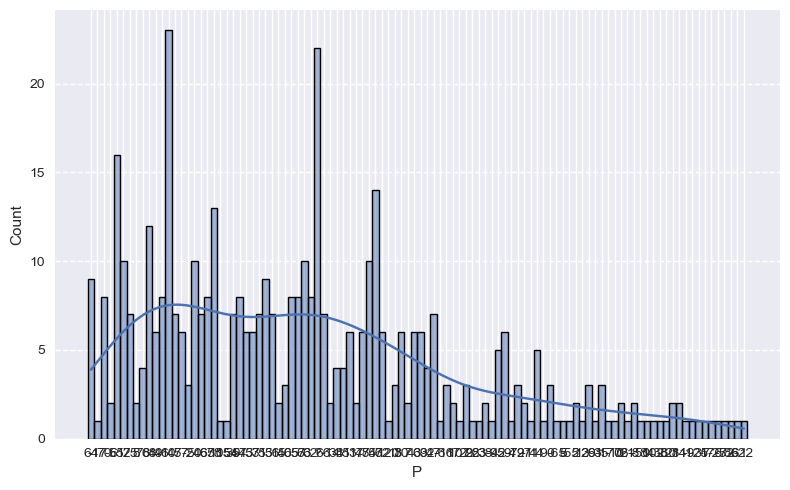

In [12]:
eda.plot_continuous_distribution(dfA['P'])

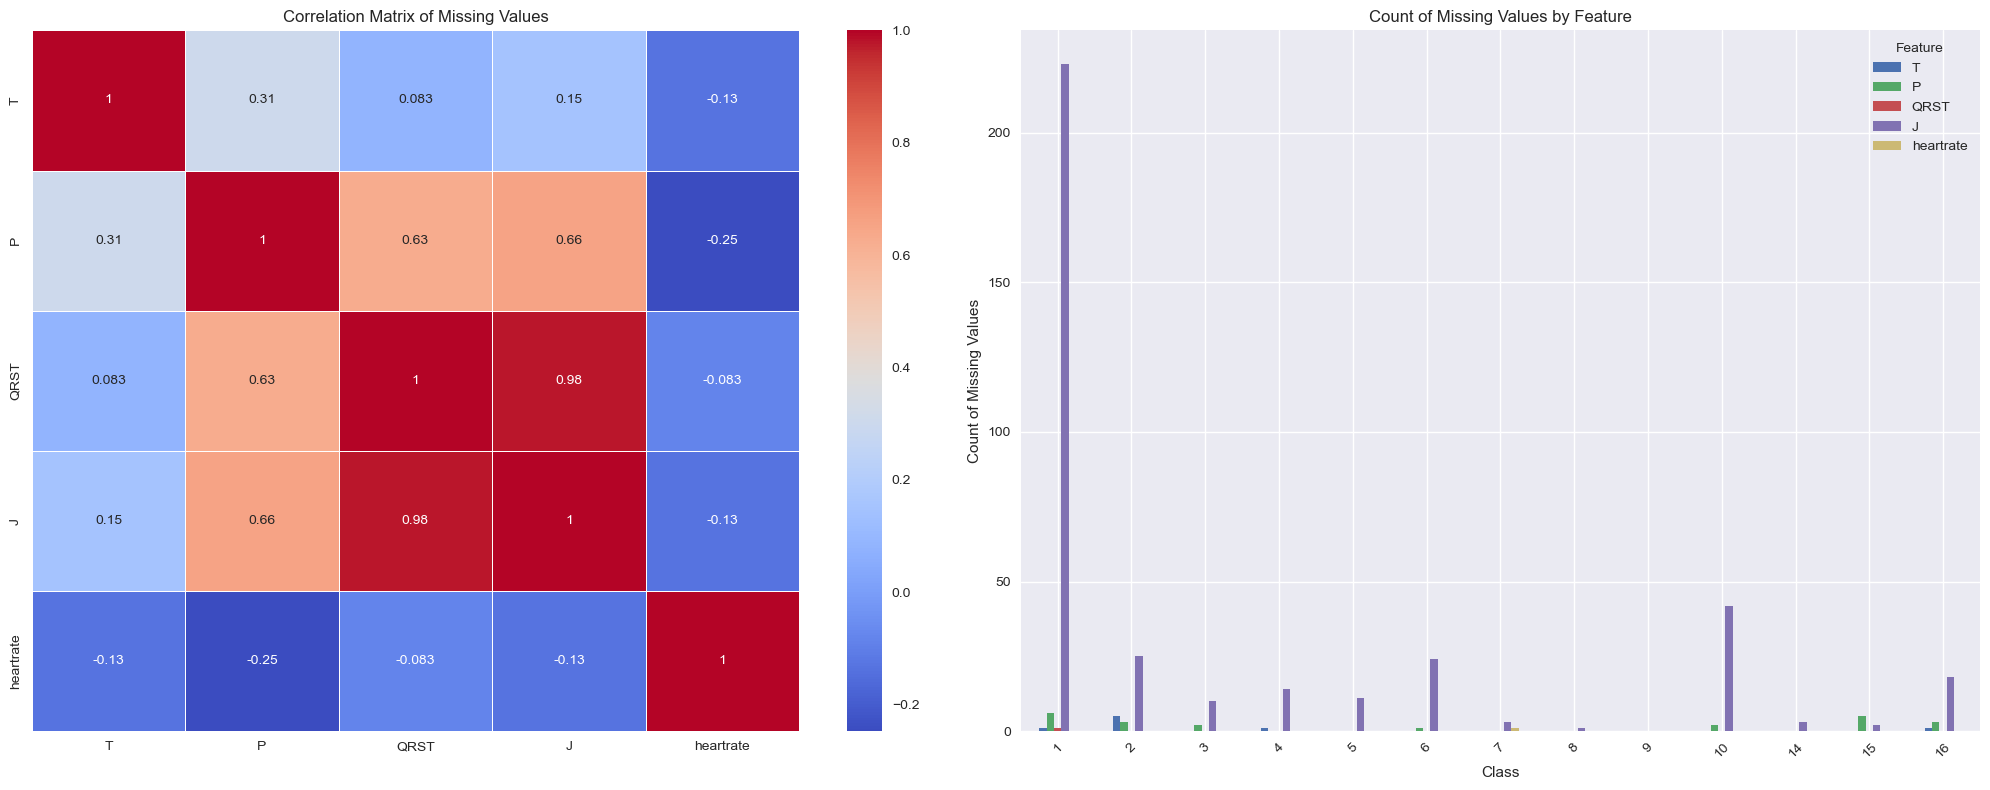

In [13]:
missing_keys = eda.displayMissingSummary(dfA).index
tmp = dfA.replace('?', np.NaN)
missing_sets = {}
for key in missing_keys:
    missing_sets[key] = tmp.groupby('class', group_keys=True)[key].apply(lambda x: x.isnull().sum())

df = pd.DataFrame(missing_sets)
correlation_matrix = df.corr(numeric_only=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=ax[0])
ax[0].set_title('Correlation Matrix of Missing Values')

df.plot(kind='bar', ax=ax[1])
ax[1].set_title('Count of Missing Values by Feature')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count of Missing Values')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(title='Feature')

plt.tight_layout()
plt.show()

#### 1.1.4 Imputing Missing Values in `Arrhythmia`

- `J` feature dropped due to high missingness.
- `QRST`, `heartrate`, `T` features imputed with zeros due to very low missingness.
- `P` feature imputed with its median value due to skewed distribution.

In [14]:
dfA = dfA.replace('?', np.NaN)

# Dropping 'J' feature
dfA=dfA.drop('J', axis=1)

# Zeros Imputation
cols_impute = ['QRST', 'heartrate', 'T']
dfA[cols_impute] = dfA[cols_impute].fillna(0)

# Median Imputation
col = 'P'
median_value = dfA[col].median()
dfA[col] = dfA[col].fillna(median_value)

In [15]:
for col in ['QRST', 'heartrate', 'T', 'P']:
    dfA[col] = pd.to_numeric(dfA[col], errors='coerce') 

In [16]:
cnt = dfA.isnull().sum()
cnt[cnt > 0]

Series([], dtype: int64)

#### 1.1.5 Initial Exploration of `BCP`

No missing values.

In [17]:
load.printSummary('BCP')

BCP
----------
Number of Examples in BCP: 683
Number of Features in BCP: 11
Arrhythmia Shape: (683, 11)
Index(['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')




In [18]:
dfB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


In [19]:
dfB.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [20]:
dfB.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

#### 1.1.6 Initial Exploration of `Website Phishing`

No missing values.

In [21]:
load.printSummary('Website_Phishing')

Website_Phishing
----------
Number of Examples in Website_Phishing: 11055
Number of Features in Website_Phishing: 31
Arrhythmia Shape: (11055, 31)
Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Class'],
      dtype='object')




In [22]:
dfC.isna().any().sum()

0

In [23]:
dfC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [24]:
dfC.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Class
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. Implementation

1. Determine whether the node is a decision or leaf node ie. data is pure/singleton. If the data is pure, we can return its value, otherwise continue recursively splitting into two or more homogeneous sets until a pure set is found.
2. The left is determined as such `feature <= threshold` and the right w/ `feature > threshold`. 
3. Following, we then need to determine the "best threshold" and therefore feature which maximises **Information Gain** (and thus minimises Entropy). 
  This will allow us to select the best split ie. the feature which provides the best homogenous subsets.
4. Continue this process, until singleton sets are found. 

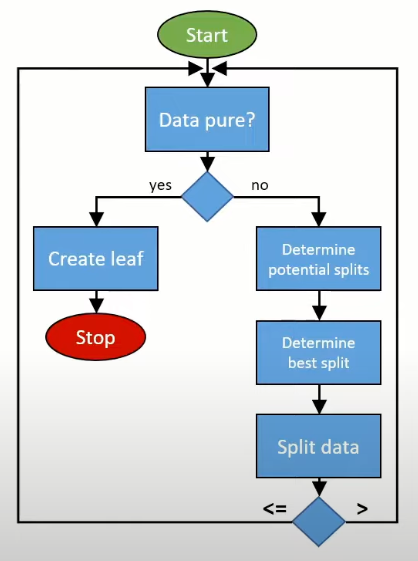

#### 2.1 Implementation of Decision Trees

In [25]:
class DecisionInterface:
    '''
    Defines an Informal Interface to be used for all Decision Tree Classifiers
    Provides blueprint for concrete class implementation
    '''
    def fit(self, X: np.ndarray, y: np.ndarray) -> pd.DataFrame:
        pass
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass

In [26]:
class Node:
    def __init__(self, feature_idx: int = None, threshold: Union[int, float, str] = None, left = None, right = None, info_gain: float = None, value: Any = None):
        
        ## for decision node
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left                     
        self.right = right
        self.info_gain = info_gain     
        
        ## for leaf nodes - majority class
        self.value = value   

In [27]:
Counter(dfA.iloc[:, -1])

Counter({8: 2,
         6: 25,
         10: 50,
         1: 245,
         7: 3,
         14: 4,
         3: 15,
         16: 22,
         2: 44,
         4: 15,
         5: 13,
         9: 9,
         15: 5})

In [28]:
np.unique(dfA.iloc[:, -1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

In [29]:
class DecisionTree(DecisionInterface):
    def __init__(self, max_depth=2, min_samples_split=2):
        self.root = None
        
        # for pre-pruning - hyperparameters
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, y):
         # Ensure y is a DataFrame with a specific column name if it's not already
        if isinstance(y, pd.Series):
            y = y.to_frame('Target')
        elif isinstance(y, pd.DataFrame):
            # Assuming y is a single-column DataFrame, you might rename the column to 'Target'
            y.columns = ['Target']
        
        # Concatenate X and y column-wise to create a new DataFrame
        dataset = pd.concat([X, y], axis=1)
        
        # Proceed with building the tree using the combined DataFrame
        self.root = self.constructTree(dataset, depth=0)
    
    def constructTree(self, df, depth):
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        n = len(df) # num. of examples
        
        if depth == self.max_depth or n < self.min_samples_split or len(y.unique()) == 1:
            value = y.mode()[0]
            return Node(value=value)
        else:
            best_split = self.getBestSplit(df)
            
            # recursive splitting
            if 'info_gain' in best_split and best_split['info_gain'] > 0:
                left = self.constructTree(best_split['df_left'], depth+1)
                right = self.constructTree(best_split['df_right'], depth+1)
                return Node(
                    feature_idx=best_split['feature_idx'],
                    threshold=best_split['threshold'],
                    left=left,
                    right=right,
                    info_gain=best_split['info_gain']
                )
            else:
                # return leaf node once splitting completed, or max depth reached.
                return Node(value=y.mode()[0])

    def getBestSplit(self, df):
        max_info_gain = float('-inf')
        best_split = {}
        
        X = df.iloc[:, :-1]

        for i, feature in enumerate(X):            
            values = X[feature].unique()
            thresholds = np.sort(values)
            
            for threshold in thresholds:
                
                # determines left / right splits
                left, right = self.split(df, feature, threshold)
                
                # updating best split only if children aren't null
                if len(left) > 0 and len(right) > 0:
                    # select target feature vector from left / right nodes
                    y = df.iloc[:, -1]
                    y_left = left.iloc[:, -1]
                    y_right = right.iloc[:, -1]
                    
                    # determine best split via information gain
                    curr_info_gain = self.calc_info_gain(y, y_left, y_right)
                    
                    # selecting the split with higher info gain = bigger drop in entropy
                    # goal: minimise entropy / maximise info gain
                    if curr_info_gain > max_info_gain:
                        best_split['feature_idx'] = i
                        best_split['threshold'] = threshold 
                        best_split['df_left'] = left
                        best_split['df_right'] = right
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
                
        return best_split
                

    def split(self, df: pd.DataFrame, feature: str, threshold: int):
        left = df[df[feature] <= threshold]
        right = df[df[feature] > threshold]
        
        return left, right
    
    def calc_info_gain(self, parent, left_child, right_child):
        ## Information Gain = E(parent) - [ (weighted) average E(children) ]
        
        left_weight = len(left_child) / len(parent)
        right_weight = len(right_child) / len(parent)
        
        gain = self.calc_entropy(parent) - left_weight * self.calc_entropy(left_child) - right_weight * self.calc_entropy(right_child)
        
        return gain
        
    def calc_entropy(self, y):
        ## Entropy = sum[ -pi log2(pi) ]
                
        labels = np.unique(y)
        freqs = Counter(y)
        entropy = 0
        
        for cls in labels:
            p = freqs[cls] / len(y)
            
            if p > 0: 
                entropy += -p * np.log2(p)
        
        return entropy

    def print_tree(self, node=None, depth=0, prefix="", feature_names=None, is_left=True):
        if node is None:
            return

        # Leaf node
        if node.value is not None:
            print(f"{prefix}Predict: {node.value}")
        else:
            # Ensure that feature_idx is within the bounds of feature_names
            if 0 <= node.feature_idx < len(feature_names):
                feature_name = feature_names[node.feature_idx]
                print(f"{prefix}{feature_name} {'<=' if is_left else '>'} {node.threshold}? Info Gain: {node.info_gain:.4f}")
            
            # Prepare the prefix for child nodes
            child_prefix = prefix + "  |"
            
            # Print child nodes
            print(f"{child_prefix}---> True:")
            self.print_tree(node.left, feature_names=feature_names, depth=depth + 1, prefix=child_prefix + "  ", is_left=True)
            
            print(f"{child_prefix}---> False:")
            self.print_tree(node.right, feature_names=feature_names, depth=depth + 1, prefix=child_prefix + "  ", is_left=False) 
            
    def predict_vals(self, X):
        return [self.predict(x, self.root) for _, x in X.iterrows()]
    
    def predict(self, instance, node):
        if node.value != None:
            return node.value
        
        if instance[node.feature_idx] <= node.threshold:
            return self.predict(instance, node.left)
            
        return self.predict(instance, node.right)

In [30]:
class DecisionTreeUnpruned(DecisionInterface):
    def __init__(self):
        self.root = None
    
    def fit(self, X, y):
        # df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        X['Target'] = y
        
        # if df.isna().any().any():
        #     df.fillna(0, inplace=True)
        
        self.root = self.constructTree(X, depth=0)
    
    def constructTree(self, df, depth):
        y = df.iloc[:, -1]

        # checking if data is pure
        if len(y.unique()) == 1:
            value = y.mode()[0]
            return Node(value=value)
        else:
            # determine all potential splits, and select best split
            best_split = self.getBestSplit(df)
            
            # recursive splitting
            if 'info_gain' in best_split and best_split['info_gain'] > 0:
                left = self.constructTree(best_split['df_left'], depth+1)
                right = self.constructTree(best_split['df_right'], depth+1)
                return Node(
                    feature_idx=best_split['feature_idx'],
                    threshold=best_split['threshold'],
                    left=left,
                    right=right,
                    info_gain=best_split['info_gain']
                )
        # return leaf node once splitting completed, or max depth reached.
        return Node(value=y.mode()[0])

    def getBestSplit(self, df):
        max_info_gain = float('-inf')
        best_split = {}
        curr_info_gain = 0
        
        X = df.iloc[:, :-1]

        # determine all potential splits
        for i, feature in enumerate(X):            
            values = X[feature].unique()
            thresholds = np.sort(values)
            
            for threshold in thresholds:
                # determines left / right splits
                left, right = self.split(df, feature, threshold)
                
                # updating best split only if children aren't null
                if len(left) > 0 and len(right) > 0:
                    # select target feature vector from left / right
                    y = df.iloc[:, -1]
                    y_left = left.iloc[:, -1]
                    y_right = right.iloc[:, -1]
                    
                    # determine best split via information gain
                    curr_info_gain = self.calc_info_gain(y, y_left, y_right)
                    
                    # selecting the split with higher info gain = bigger drop in entropy
                    # goal: minimise entropy / maximise info gain
                    if curr_info_gain > max_info_gain:
                        best_split['feature_idx'] = i
                        best_split['threshold'] = threshold 
                        best_split['df_left'] = left
                        best_split['df_right'] = right
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
                
        return best_split

    def split(self, df: pd.DataFrame, feature: str, threshold: int):
        left = df[df[feature] <= threshold]
        right = df[df[feature] > threshold]
        
        return left, right
    
    def calc_info_gain(self, parent, left_child, right_child):
        ## Information Gain = E(parent) - [ (weighted) average E(children) ]
        
        left_weight = len(left_child) / len(parent)
        right_weight = len(right_child) / len(parent)
        
        gain = self.calc_entropy(parent) - (left_weight * self.calc_entropy(left_child)) - (right_weight * self.calc_entropy(right_child))
        
        return gain
        
    def calc_entropy(self, y):
        ## Entropy = sum[ -pi log2(pi) ]
                
        labels = np.unique(y)
        freqs = Counter(y)
        entropy = 0
        
        for cls in labels:
            p = freqs[cls] / len(y)
            entropy += -p * np.log2(p)
        
        return entropy

    def print_tree(self, node=None, depth=0, prefix="", feature_names=None, is_left=True):
        if node is None:
            return 

        # Leaf node
        if node.value is not None:
            print(f"{prefix}Predict: {node.value}")
        else:
            # Ensure that feature_idx is within the bounds of feature_names
            if 0 <= node.feature_idx < len(feature_names):
                feature_name = feature_names[node.feature_idx]
                print(f"{prefix}{feature_name} {'<=' if is_left else '>'} {node.threshold}? Info Gain: {node.info_gain:.4f}")
            
            # Prepare the prefix for child nodes
            child_prefix = prefix + "  |"
            
            # Print child nodes
            print(f"{child_prefix}---> True:")
            self.print_tree(node.left, feature_names=feature_names, depth=depth + 1, prefix=child_prefix + "  ", is_left=True)
            
            print(f"{child_prefix}---> False:")
            self.print_tree(node.right, feature_names=feature_names, depth=depth + 1, prefix=child_prefix + "  ", is_left=False)    
    
    def predict_vals(self, X):
        return [self.predict(x, self.root) for _, x in X.iterrows()]
    
    def predict(self, instance, node):
        if node.value != None:
            return node.value
        
        if instance[node.feature_idx] <= node.threshold:
            return self.predict(instance, node.left)
            
        return self.predict(instance, node.right)

### Train Test Split

Partitioning w/ a 80-20 split for training and testing using `train_test_split()`

In [31]:
dfA_X_train, dfA_X_test, dfA_y_train, dfA_y_test = eda.data_split(dfA)
dfB_X_train, dfB_X_test, dfB_y_train, dfB_y_test = eda.data_split(dfB)
dfC_X_train, dfC_X_test, dfC_y_train, dfC_y_test = eda.data_split(dfC)

dfA_y_train = pd.DataFrame(dfA_y_train)
dfB_y_train = pd.DataFrame(dfB_y_train)
dfC_y_train = pd.DataFrame(dfC_y_train)

### Decision Stump

One-layer decision tree, makes simple predictions.

In [32]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=1, min_samples_split=2)

# Fit the classifier on the training data
clf.fit(dfA_X_train, dfA_y_train)

# Make predictions on the testing set
y_pred = clf.predict(dfA_X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(dfA_y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5164835164835165


In [33]:
clf = DecisionTree(max_depth=1)
clf.fit(dfA_X_train, dfA_y_train)
clf.print_tree(clf.root, feature_names=dfA_X_train.columns)

y_pred = clf.predict_vals(dfA_X_test)
accuracy_score(dfA_y_test, y_pred)

print(f"\nDecision Stump Predictions for Arrhythmia: {accuracy_score(dfA_y_test, y_pred)}")

chV6_PwaveAmp <= 0.5? Info Gain: 0.4855
  |---> True:
  |  Predict: 1.0
  |---> False:
  |  Predict: 1.0

Decision Stump Predictions for Arrhythmia: 0.4835164835164835


In [34]:
clf = DecisionTree(max_depth=1)
clf.fit(dfB_X_train, dfB_y_train)
clf.print_tree(clf.root, feature_names=dfB_X_train.columns)

y_pred = clf.predict_vals(dfB_X_test)
accuracy_score(dfB_y_test, y_pred)

print(f"\nDecision Stump Predictions for BCP: {accuracy_score(dfB_y_test, y_pred)}")

Sample code number <= 1321942.0? Info Gain: 0.2236
  |---> True:
  |  Predict: 2.0
  |---> False:
  |  Predict: 2.0

Decision Stump Predictions for BCP: 0.5766423357664233


In [35]:
clf = DecisionTree(max_depth=1)
clf.fit(dfC_X_train, dfC_y_train)
clf.print_tree(clf.root, feature_names=dfC_X_train.columns)

y_pred = clf.predict_vals(dfC_X_test)
accuracy_score(dfC_y_test, y_pred)

print(f"\nDecision Stump Predictions for Website Phishing: {accuracy_score(dfC_y_test, y_pred)}")

age_of_domain <= -1.0? Info Gain: 0.1827
  |---> True:
  |  Predict: 1.0
  |---> False:
  |  Predict: 1.0

Decision Stump Predictions for Website Phishing: 0.5676164631388512


### Unpruned Decision Tree

Unconstrained Tree that grows until singleton sets at the leaves. Prone to overfitting, shouldn't be used for testing or making predictions; incurs high bias towards training.

In [36]:
clf = DecisionTreeUnpruned()
clf.fit(dfA_X_train, dfA_y_train)
y_pred = clf.predict_vals(dfA_X_test)
accuracy_score(dfA_y_test, y_pred)

print(f"Unpruned Decision Tree Predictions for Arrhythmia: {accuracy_score(dfA_y_test, y_pred)}")

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: divide by zero encountered in log2
  entropy += -p * np.log2(p)
/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: invalid value encountered in scalar multiply
  entropy += -p * np.log2(p)


Unpruned Decision Tree Predictions for Arrhythmia: 0.4835164835164835


In [37]:
clf = DecisionTreeUnpruned()
clf.fit(dfB_X_train, dfB_y_train)
y_pred = clf.predict_vals(dfB_X_test)
accuracy_score(dfB_y_test, y_pred)

print(f"Unpruned Decision Tree Predictions for BCP: {accuracy_score(dfB_y_test, y_pred)}")

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: divide by zero encountered in log2
  entropy += -p * np.log2(p)
/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: invalid value encountered in scalar multiply
  entropy += -p * np.log2(p)


Unpruned Decision Tree Predictions for BCP: 0.5766423357664233


In [38]:
clf = DecisionTreeUnpruned()
clf.fit(dfC_X_train, dfC_y_train)
y_pred = clf.predict_vals(dfC_X_test)
accuracy_score(dfC_y_test, y_pred)

print(f"Unpruned Decision Tree Website Phishing: {accuracy_score(dfC_y_test, y_pred)}")

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: divide by zero encountered in log2
  entropy += -p * np.log2(p)
/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3354856752.py:102: RuntimeWarning: invalid value encountered in scalar multiply
  entropy += -p * np.log2(p)


Unpruned Decision Tree Website Phishing: 0.5676164631388512


### Pre Pruning Approach (Early Stopping)

This helped to control the size of the tree and prevent overfitting to the noise in the training. 

- Limiting Tree Depth - Constrained the tree to not grow beyond `max_depth` so that the tree doesn't grow to become too complex and fit to the noise of training.
- Min. Samples Split - Checking the number of samples required to split a decision node.

### Manual Hyperparameter Testing

Below is used because the above solutions take too long and is too taxing to run everytime for new results ie. infeasible (~30 minutes). 

The risk with Manual Hyperparameter Tuning is that the chosen hyperparameters can potentially be suboptimal. 

The optimal hyperparameters found were :
> Arrhythmia : `{'max_depth': 9, 'min_samples_split': 10}`

> BCP: `{'max_depth': 7, 'min_samples_split': 8}`

> Website Phishing: `{'max_depth': 10, 'min_samples_split': 8}`

In [39]:
%%time
best_score = 0
max_depths = [2,4,6,8,10]
min_samples_split = [2,4,6,8]

best_params = {'max_depth': None, 'min_samples_split': None}
combinations = list(product(max_depths, min_samples_split))

k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=42)

dfA_y_train = pd.DataFrame(dfA_y_train)

for max_depth, min_sample_split in combinations:
  cv_scores = []
  
  for train_idx, test_idx in kf.split(dfA_X_train):
    X_train_fold = dfA_X_train.iloc[train_idx]
    X_test_fold = dfA_X_train.iloc[test_idx]

    y_train_fold = dfA_y_train.iloc[train_idx]
    y_test_fold = dfA_y_train.iloc[test_idx]
    
    clf = DecisionTree(max_depth=max_depth, min_samples_split=min_sample_split)
    clf.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = clf.predict_vals(X_test_fold)
    
    fold_acc = accuracy_score(y_test_fold, y_pred_fold)
    cv_scores.append(fold_acc)
    
  # avg score across all folds
  avg_cv_score = np.mean(cv_scores)
  
  # Update best score and parameters if current combination is better
  if avg_cv_score > best_score:
      best_score = avg_cv_score
      best_params['max_depth'] = max_depth
      best_params['min_samples_split'] = min_sample_split
  
print("Best Score (Average CV Accuracy):", best_score)
print("Best Hyperparameters:", best_params)

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3419951206.py:89: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  left = df[df[feature] <= threshold]


ValueError: cannot reindex on an axis with duplicate labels

In [40]:
%%time
best_score = 0
max_depths = [5,6,7,8,9,10]
min_samples_split = [8,9,10]

best_params = {'max_depth': None, 'min_samples_split': None}
combinations = list(product(max_depths, min_samples_split))

k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for max_depth, min_sample_split in combinations:
  cv_scores = []
  
  for train_idx, test_idx in kf.split(dfB_X_train):
    X_train_fold = dfB_X_train.iloc[train_idx]
    X_test_fold = dfB_X_train.iloc[test_idx]

    y_train_fold = dfB_y_train.iloc[train_idx]
    y_test_fold = dfB_y_train.iloc[test_idx]
    
    clf = DecisionTree(max_depth=max_depth, min_samples_split=min_sample_split)
    clf.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = clf.predict_vals(X_test_fold)
    
    fold_acc = accuracy_score(y_test_fold, y_pred_fold)
    cv_scores.append(fold_acc)
    
  # avg score across all folds
  avg_cv_score = np.mean(cv_scores)
  
  # Update best score and parameters if current combination is better
  if avg_cv_score > best_score:
      best_score = avg_cv_score
      best_params['max_depth'] = max_depth
      best_params['min_samples_split'] = min_sample_split
  
print("Best Score (Average CV Accuracy):", best_score)
print("Best Hyperparameters:", best_params)

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3419951206.py:89: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  left = df[df[feature] <= threshold]


ValueError: cannot reindex on an axis with duplicate labels

In [41]:
%%time
best_score = 0
max_depths = [5,6,7,8,9,10]
min_samples_split = [8,9,10]

best_params = {'max_depth': None, 'min_samples_split': None}
combinations = list(product(max_depths, min_samples_split))

k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for max_depth, min_sample_split in combinations:
  cv_scores = []
  
  for train_idx, test_idx in kf.split(dfC_X_train):
    X_train_fold = dfC_X_train.iloc[train_idx]
    X_test_fold = dfC_X_train.iloc[test_idx]

    y_train_fold = dfC_y_train.iloc[train_idx]
    y_test_fold = dfC_y_train.iloc[test_idx]
    
    clf = DecisionTree(max_depth=max_depth, min_samples_split=min_sample_split)
    clf.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = clf.predict_vals(X_test_fold)
    
    fold_acc = accuracy_score(y_test_fold, y_pred_fold)
    cv_scores.append(fold_acc)
    
  # avg score across all folds
  avg_cv_score = np.mean(cv_scores)
  
  # Update best score and parameters if current combination is better
  if avg_cv_score > best_score:
      best_score = avg_cv_score
      best_params['max_depth'] = max_depth
      best_params['min_samples_split'] = min_sample_split
  
print("Best Score (Average CV Accuracy):", best_score)
print("Best Hyperparameters:", best_params)

/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3419951206.py:89: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  left = df[df[feature] <= threshold]


ValueError: cannot reindex on an axis with duplicate labels

### Discussion

#### **Arrhythmia**
None of the comparisons show statistically significant differences in performance among the three configurations. The complexity added by unpruning or the simplicity of a stump does not substantially affect the model's ability to generalize from the data, at least not to a degree detectable by this test. It might also suggest that the dataset's characteristics or the features used do not significantly benefit from the additional complexity of deeper trees or the constraints imposed by pruning.

However, a t-test doesn't tell the whole story. Other metrics like precision, recall, F1 score could provide addiitonal insights and may be needed.

#### **BCP**
There is differences in performance between the three decision trees. The significant difference between the stump and both the pruned and unpruned trees, suggests that for the BCP dataset, a simpler model (decision stump) may be more effective. This could indicate that the dataset or the problem it represents may be sufficiently addressed by capturing a primary decision rule, or it could suggest that the complexity added by deeper trees may lead to overfitting, reducing their effectiveness. 

The BCP dataset, with its particular features, size, and underlying patterns, seems to favor simpler models over highly complex ones, with pruned trees striking a balance that yields improved performance.

#### **Website Phishing**
The Website Phishing dataset appears to benefit from the additional complexity of unpruned trees, as indicated by their superior performance compared to both pruned trees and decision stumps. This could be due to the dataset containing complex patterns or relationships that require a more detailed model to capture accurately. 

While the decision stump outperforms pruned trees, suggesting some level of simplicity might be beneficial, the stark difference in performance between the stump and unpruned trees underscores that too much simplification (as in the case of a stump) is detrimental, likely due to underfitting.

The significant performance gap between pruned and unpruned trees, as well as between pruned trees and stumps, suggests that the pruning process might be overly aggressive or not well-tuned for this dataset. Pruning, when applied correctly, should help mitigate overfitting while preserving the model's ability to generalize; however, finding the right balance is crucial.



Used StratefiedKFold over KFold for evaluating accuracy as it perserves the percentage of samples for each class.

In [42]:
def cross_validate(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # ensures each fold has a similar distribution of classes as the original dataset 
    scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train= y.iloc[train_index]
        y_test = y.iloc[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict_vals(X_test)
        score = accuracy_score(y_test, predictions)
        scores.append(score)

    return scores

In [43]:
scores_pruned = cross_validate(DecisionTree(max_depth=9, min_samples_split=10), X=dfA_X_train, y=dfA_y_train)
scores_unpruned = cross_validate(DecisionTreeUnpruned(), X=dfA_X_train, y=dfA_y_train)
scores_stump = cross_validate(DecisionTree(max_depth=1, min_samples_split=0), X=dfA_X_train, y=dfA_y_train)

/Users/mchh528/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


/var/folders/pm/yn_p2yr558z2s_qmmfxgykqc0000gn/T/ipykernel_60952/3419951206.py:89: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  left = df[df[feature] <= threshold]


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
print("----Arrhythmia Results----")

t_stat, p_val = ttest_ind(scores_pruned, scores_unpruned)
print(f"Unpruned vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_pruned, scores_stump)
print(f"Stump vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_stump, scores_unpruned)
print(f"Stump vs Unpruned: T-statistic: {t_stat}, P-value: {p_val}")

----Arrhythmia Results----
Unpruned vs Pruned: T-statistic: 0.17422587345738694, P-value: 0.8660161836006354
Stump vs Pruned: T-statistic: -1.2600267781603136, P-value: 0.24317177891102268
Stump vs Unpruned: T-statistic: 1.335463120304033, P-value: 0.21847156021912162


In [ ]:
scores_pruned = cross_validate(DecisionTree(max_depth=7, min_samples_split=8), X=dfB_X_train, y=dfB_y_train)
scores_unpruned = cross_validate(DecisionTreeUnpruned(), X=dfB_X_train, y=dfB_y_train)
scores_stump = cross_validate(DecisionTree(max_depth=1, min_samples_split=0), X=dfB_X_train, y=dfB_y_train)

In [ ]:
print("----BCP Results----")

t_stat, p_val = ttest_ind(scores_pruned, scores_unpruned)
print(f"Unpruned vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_pruned, scores_stump)
print(f"Stump vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_stump, scores_unpruned)
print(f"Stump vs Unpruned: T-statistic: {t_stat}, P-value: {p_val}")

----BCP Results----
Unpruned vs Pruned: T-statistic: 1.5452254187776269, P-value: 0.16087337156330278
Stump vs Pruned: T-statistic: -3.2453556010076374, P-value: 0.011782731278054544
Stump vs Unpruned: T-statistic: 13.4687385846037, P-value: 8.853338651031552e-07


In [ ]:
scores_pruned = cross_validate(DecisionTree(max_depth=10, min_samples_split=8), X=dfC_X_train, y=dfC_y_train)
scores_unpruned = cross_validate(DecisionTreeUnpruned(), X=dfC_X_train, y=dfC_y_train)
scores_stump = cross_validate(DecisionTree(max_depth=1, min_samples_split=0), X=dfC_X_train, y=dfC_y_train)

In [ ]:
print("----Website Phishing Results----")

t_stat, p_val = ttest_ind(scores_pruned, scores_unpruned)
print(f"Unpruned vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_pruned, scores_stump)
print(f"Stump vs Pruned: T-statistic: {t_stat}, P-value: {p_val}")

t_stat, p_val = ttest_ind(scores_stump, scores_unpruned)
print(f"Stump vs Unpruned: T-statistic: {t_stat}, P-value: {p_val}")

----Website Phishing Results----
Unpruned vs Pruned: T-statistic: 3.1211502780056666, P-value: 0.014203966205308075
Stump vs Pruned: T-statistic: 8.959728848106556, P-value: 1.9152110380460406e-05
Stump vs Unpruned: T-statistic: -18.882496349301622, P-value: 6.397999556997524e-08
